In [35]:
from resnet import *
from cnn import *
from augment_data import PositionalAugmentation

import torch, random, os
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [36]:
def set_random_seed(seed: int):
    """
    Helper function to seed experiment for reproducibility.
    If -1 is provided as seed, experiment uses random seed from 0~9999
    Args:
        seed (int): integer to be used as seed, use -1 to randomly seed experiment
    """
    print("Seed: {}".format(seed))

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [37]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001
SEED = 2809
SAVE_STATE_PATH = "Model_Saves/"

In [38]:
set_random_seed(SEED)

Seed: 2809


In [39]:
def get_loss_curves(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

def get_accuracy_curves(train_accuracy, val_accuracy):
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [40]:
def train(model, train_dataloader, val_dataloader, train_samples, val_samples, optimizer, criterion):
    print("training...")

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(NUM_EPOCHS):
        t_loss = 0
        v_loss = 0
        train_total_correct = 0
        val_total_correct = 0

        for batch in train_dataloader:
            X, labels = batch

            X = X.cuda()
            labels = labels.cuda()

            X = X.to(torch.float32)

            preds = model(X)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            train_total_correct += get_num_correct(preds, labels)
        
        print("\n------ Evaluating on Validation Set ------\n")
        with torch.no_grad():
            for batch in val_dataloader:
                X, labels = batch

                X = X.cuda()
                labels = labels.cuda()

                preds = model(X)
                loss = criterion(preds, labels)

                v_loss += loss.item()
                val_total_correct += get_num_correct(preds, labels)
        
        train_loss.append(t_loss / train_samples)
        val_loss.append(v_loss / val_samples)

        train_accuracy.append(100*train_total_correct / train_samples)
        val_accuracy.append(100*val_total_correct / val_samples)

        print('Epoch: {} of {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch+1, NUM_EPOCHS, train_loss[-1], train_accuracy[-1]))
        print('\t\tValidation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(val_loss[-1], val_accuracy[-1]))
    return model, train_loss, val_loss, train_accuracy, val_accuracy, optimizer

In [41]:
def eval(model, test_dataloader, criterion):
    print("\n------ Inference on Test Set ------\n")
    test_loss = 0
    test_total_correct = 0
    with torch.no_grad():
        for batch in test_dataloader:
            X, labels = batch

            X = X.cuda()
            labels = labels.cuda()

            preds = model(X)
            loss = criterion(preds, labels)

            test_loss += loss.item()
            test_total_correct += get_num_correct(preds, labels)

    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss / len(test_dataloader.dataset), 100*test_total_correct / len(test_dataloader.dataset)))

In [42]:
torch.manual_seed(SEED)

In [43]:
train_set = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [44]:
train_idx, val_idx = train_test_split(range(data_loader.dataset.targets.shape[0]), test_size=0.2, stratify=data_loader.dataset.targets, random_state=SEED)

In [45]:
train_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=train_idx)
val_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=val_idx)

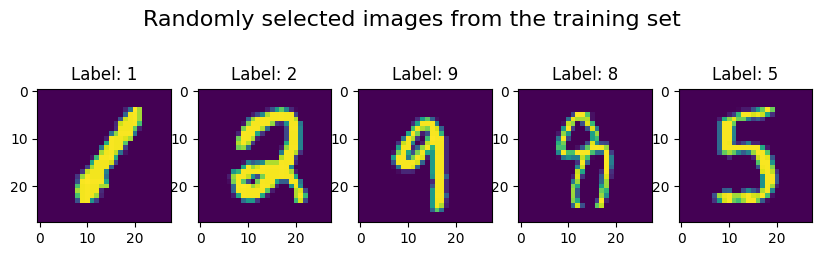

In [46]:
for i in train_dataloader:
    visualize_data(i)
    break

In [47]:
posaug = PositionalAugmentation()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

In [48]:
augmentation_splits = []

In [49]:
_, aug_idx = next(sss.split(train_idx, train_dataloader.dataset.targets[train_idx]))

### Left-flip

In [50]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [51]:
left_flip_augmentation_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=aug_idx)
left_flip_augmented_data = posaug.augment_data(left_flip_augmentation_dataloader.dataset.data[aug_idx], left_flip_augmentation_dataloader.dataset.targets[aug_idx], "left_flip")

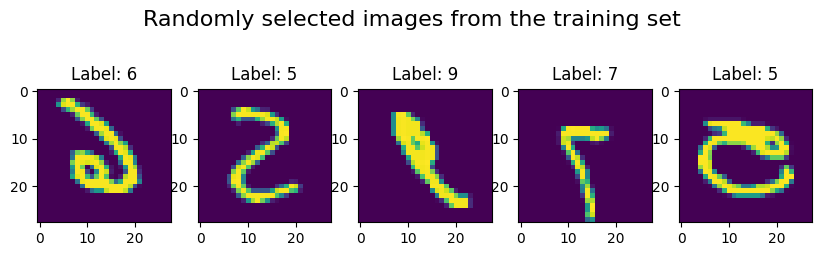

In [52]:
visualize_data(left_flip_augmented_data)

In [53]:
left_flip_augmented_train_dataloader = DataLoader(torch.utils.data.TensorDataset(left_flip_augmented_data[0], left_flip_augmented_data[1]), batch_size=128)

In [54]:
left_flip_train_ds = []
for i in train_dataloader:
    left_flip_train_ds.append(i)

for i in left_flip_augmented_train_dataloader:
    left_flip_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

In [55]:
train_samples, val_samples = 0, 0

for i in left_flip_train_ds:
    train_samples += i[-1].shape[0]

for i in val_dataloader:
    val_samples += i[-1].shape[0]

In [56]:
left_flipped_model, train_loss, val_loss, train_accuracy, val_accuracy, optimizer = train(model, left_flip_train_ds, val_dataloader, train_samples, val_samples, optimizer, criterion)

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 25, Training Loss: 0.0151, Training Accuracy: 60.5295
		Validation Loss: 0.0137, Validation Accuracy: 73.0583

------ Evaluating on Validation Set ------

Epoch: 2 of 25, Training Loss: 0.0128, Training Accuracy: 84.7517
		Validation Loss: 0.0132, Validation Accuracy: 78.7000

------ Evaluating on Validation Set ------

Epoch: 3 of 25, Training Loss: 0.0125, Training Accuracy: 87.0260
		Validation Loss: 0.0130, Validation Accuracy: 80.4833

------ Evaluating on Validation Set ------

Epoch: 4 of 25, Training Loss: 0.0124, Training Accuracy: 87.9462
		Validation Loss: 0.0129, Validation Accuracy: 82.2417

------ Evaluating on Validation Set ------

Epoch: 5 of 25, Training Loss: 0.0124, Training Accuracy: 88.7049
		Validation Loss: 0.0128, Validation Accuracy: 83.6000

------ Evaluating on Validation Set ------

Epoch: 6 of 25, Training Loss: 0.0123, Training Accuracy: 89.3802
		Validation Loss: 0.0127, Validation Accu

In [57]:
eval(left_flipped_model, test_dataloader, criterion)


------ Inference on Test Set ------

Test Loss: 0.0121, Test Accuracy: 93.1300


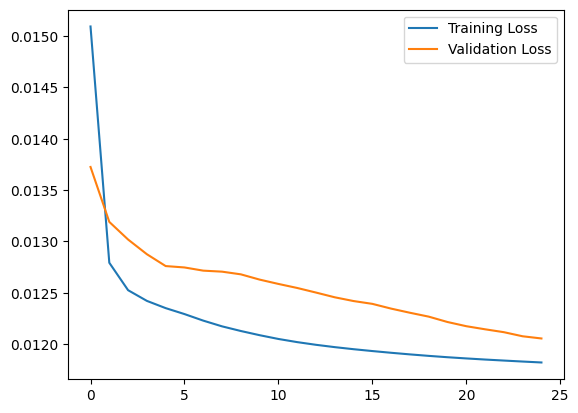

In [58]:
get_loss_curves(train_loss, val_loss)

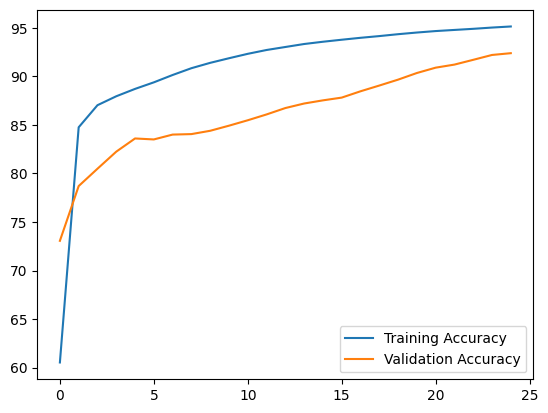

In [59]:
get_accuracy_curves(train_accuracy, val_accuracy)

### Rotation

In [60]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [61]:
rotate_augmentation_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=aug_idx)
rotate_augmented_data = posaug.augment_data(rotate_augmentation_dataloader.dataset.data[aug_idx], rotate_augmentation_dataloader.dataset.targets[aug_idx], "rotate")

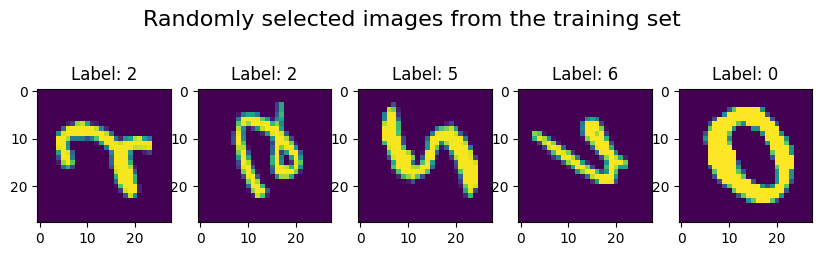

In [62]:
visualize_data(rotate_augmented_data)

In [63]:
rotate_augmented_train_dataloader = DataLoader(torch.utils.data.TensorDataset(rotate_augmented_data[0], rotate_augmented_data[1]), batch_size=128)

In [64]:
rotate_train_ds = []
for i in train_dataloader:
    rotate_train_ds.append(i)

for i in rotate_augmented_train_dataloader:
    rotate_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

In [65]:
rotate_model, train_loss, val_loss, train_accuracy, val_accuracy, optimizer = train(model, rotate_train_ds, val_dataloader, train_samples, val_samples, optimizer, criterion)

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 25, Training Loss: 0.0155, Training Accuracy: 52.5920
		Validation Loss: 0.0146, Validation Accuracy: 62.0417

------ Evaluating on Validation Set ------

Epoch: 2 of 25, Training Loss: 0.0136, Training Accuracy: 73.3090
		Validation Loss: 0.0142, Validation Accuracy: 65.9250

------ Evaluating on Validation Set ------

Epoch: 3 of 25, Training Loss: 0.0134, Training Accuracy: 74.8663
		Validation Loss: 0.0138, Validation Accuracy: 70.3667

------ Evaluating on Validation Set ------

Epoch: 4 of 25, Training Loss: 0.0133, Training Accuracy: 76.2587
		Validation Loss: 0.0134, Validation Accuracy: 75.5833

------ Evaluating on Validation Set ------

Epoch: 5 of 25, Training Loss: 0.0129, Training Accuracy: 81.7951
		Validation Loss: 0.0131, Validation Accuracy: 79.1750

------ Evaluating on Validation Set ------

Epoch: 6 of 25, Training Loss: 0.0127, Training Accuracy: 84.3142
		Validation Loss: 0.0131, Validation Accu

In [66]:
eval(rotate_model, test_dataloader, criterion)


------ Inference on Test Set ------

Test Loss: 0.0121, Test Accuracy: 93.4300


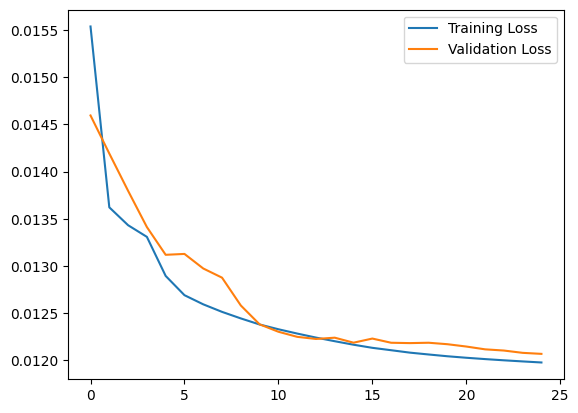

In [67]:
get_loss_curves(train_loss, val_loss)

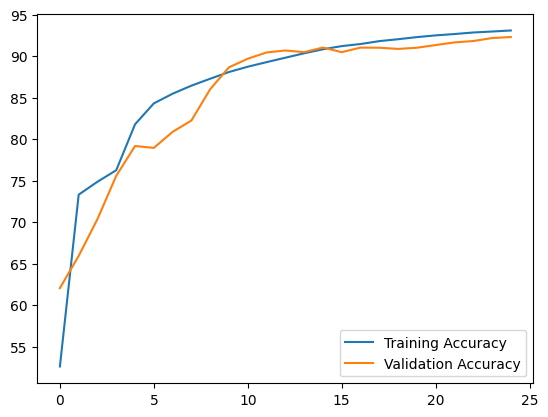

In [68]:
get_accuracy_curves(train_accuracy, val_accuracy)

### Gaussian Noise

In [69]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [70]:
gaussian_augmentation_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=aug_idx)
gaussian_augmented_data = posaug.augment_data(gaussian_augmentation_dataloader.dataset.data[aug_idx], gaussian_augmentation_dataloader.dataset.targets[aug_idx], "gaussian_noise")

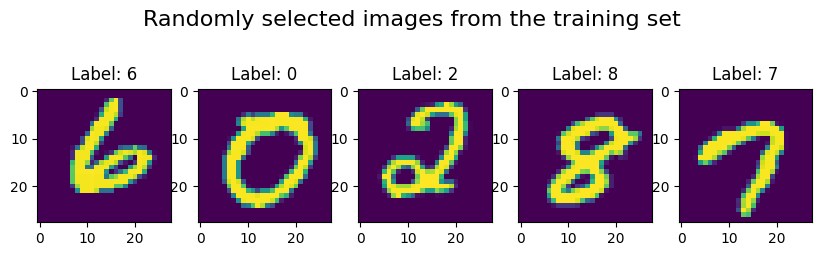

In [71]:
visualize_data(gaussian_augmented_data)

In [72]:
gaussian_augmented_train_dataloader = DataLoader(torch.utils.data.TensorDataset(gaussian_augmented_data[0], gaussian_augmented_data[1]), batch_size=128)

In [73]:
gaussian_train_ds = []
for i in train_dataloader:
    gaussian_train_ds.append(i)

for i in gaussian_augmented_train_dataloader:
    gaussian_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

In [74]:
gaussian_model, train_loss, val_loss, train_accuracy, val_accuracy, optimizer = train(model, gaussian_train_ds, val_dataloader, train_samples, val_samples, optimizer, criterion)

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 25, Training Loss: 0.0149, Training Accuracy: 64.4931
		Validation Loss: 0.0127, Validation Accuracy: 88.3333

------ Evaluating on Validation Set ------

Epoch: 2 of 25, Training Loss: 0.0123, Training Accuracy: 90.6719
		Validation Loss: 0.0122, Validation Accuracy: 92.1750

------ Evaluating on Validation Set ------

Epoch: 3 of 25, Training Loss: 0.0121, Training Accuracy: 93.0017
		Validation Loss: 0.0120, Validation Accuracy: 93.6917

------ Evaluating on Validation Set ------

Epoch: 4 of 25, Training Loss: 0.0119, Training Accuracy: 94.2309
		Validation Loss: 0.0119, Validation Accuracy: 94.5583

------ Evaluating on Validation Set ------

Epoch: 5 of 25, Training Loss: 0.0119, Training Accuracy: 95.0417
		Validation Loss: 0.0119, Validation Accuracy: 95.0500

------ Evaluating on Validation Set ------

Epoch: 6 of 25, Training Loss: 0.0118, Training Accuracy: 95.7222
		Validation Loss: 0.0118, Validation Accu

In [75]:
eval(gaussian_model, test_dataloader, criterion)


------ Inference on Test Set ------

Test Loss: 0.0117, Test Accuracy: 98.2300


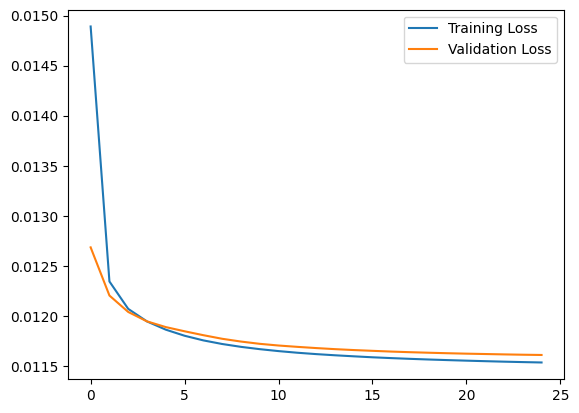

In [76]:
get_loss_curves(train_loss, val_loss)

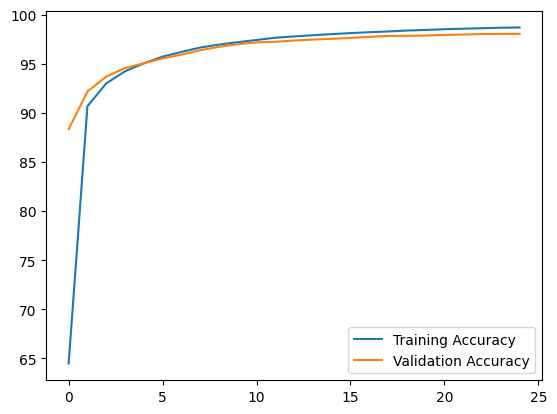

In [77]:
get_accuracy_curves(train_accuracy, val_accuracy)

### Combining all augmentation methods

In [78]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [79]:
combined_train_ds = []
for i in train_dataloader:
    combined_train_ds.append(i)

for i in left_flip_augmented_train_dataloader:
    combined_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

for i in rotate_augmented_train_dataloader:
    combined_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

for i in gaussian_augmented_train_dataloader:
    combined_train_ds.append([(i[0]/255).reshape(left_flip_train_ds[0][0].shape), i[1]])

In [80]:
train_samples = 0
val_samples = 0

for i in combined_train_ds:
    train_samples += i[-1].shape[0]

for i in val_dataloader:
    val_samples += i[-1].shape[0]

In [81]:
combined_model, train_loss, val_loss, train_accuracy, val_accuracy, optimizer = train(model, combined_train_ds, val_dataloader, train_samples, val_samples, optimizer, criterion)

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 25, Training Loss: 0.0152, Training Accuracy: 57.2786
		Validation Loss: 0.0129, Validation Accuracy: 85.3333

------ Evaluating on Validation Set ------

Epoch: 2 of 25, Training Loss: 0.0132, Training Accuracy: 79.3581
		Validation Loss: 0.0123, Validation Accuracy: 90.1667

------ Evaluating on Validation Set ------

Epoch: 3 of 25, Training Loss: 0.0129, Training Accuracy: 82.3307
		Validation Loss: 0.0122, Validation Accuracy: 91.7500

------ Evaluating on Validation Set ------

Epoch: 4 of 25, Training Loss: 0.0127, Training Accuracy: 83.8125
		Validation Loss: 0.0121, Validation Accuracy: 92.9417

------ Evaluating on Validation Set ------

Epoch: 5 of 25, Training Loss: 0.0127, Training Accuracy: 84.8477
		Validation Loss: 0.0120, Validation Accuracy: 93.4833

------ Evaluating on Validation Set ------

Epoch: 6 of 25, Training Loss: 0.0126, Training Accuracy: 85.6497
		Validation Loss: 0.0120, Validation Accu

In [82]:
eval(combined_model, test_dataloader, criterion)


------ Inference on Test Set ------

Test Loss: 0.0117, Test Accuracy: 97.6400


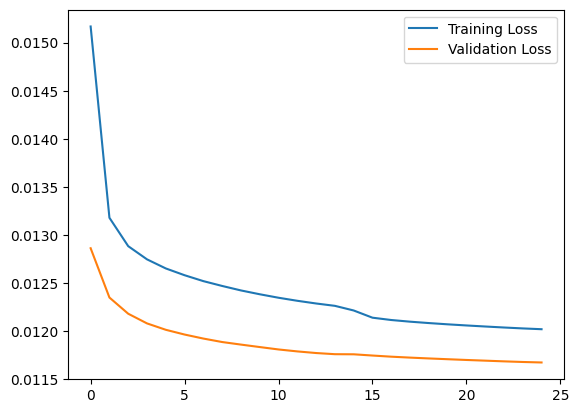

In [83]:
get_loss_curves(train_loss, val_loss)

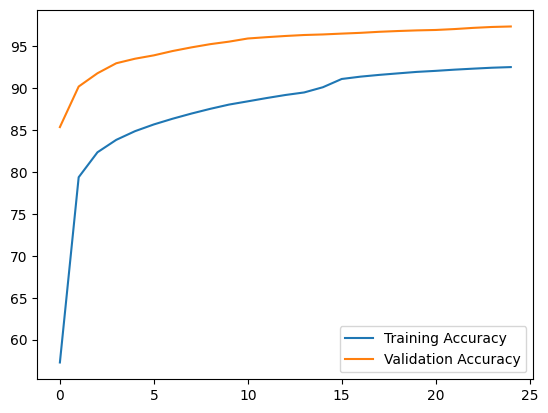

In [84]:
get_accuracy_curves(train_accuracy, val_accuracy)

#### Saving and Loading the Saved Model

In [51]:
# torch.save(left_flipped_model.state_dict(), SAVE_STATE_PATH+"left_flip.pt")
# torch.save(rotate_model.state_dict(), SAVE_STATE_PATH+"rotate.pt")
# torch.save(gaussian_model.state_dict(), SAVE_STATE_PATH+"gaussian_noise.pt")
# torch.save(combined_model.state_dict(), SAVE_STATE_PATH+"combined.pt")

In [52]:
# model = CNN()
# model.load_state_dict(torch.load(SAVE_STATE_PATH))